In [2]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", RuntimeWarning)

import sys
sys.path.append('../../dstorch/')

import pandas as pd
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [15]:
from dstorch import io, dataset, transforms, losses, models, predict, draw, utils
from dstorch.train import train
from dstorch.utils import variable
import torch.backends.cudnn as cudnn
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm_notebook, tqdm
import numpy as np
import cv2
import skimage
from skimage import img_as_ubyte
import scipy.ndimage as nd

In [4]:
TRAIN_PATH = '../../kaggle-dsbowl-2018-dataset-fixes/stage1_train/'
TEST_PATH = '../../stage1_test/'

ids, images, masks = io.read_train_data(TRAIN_PATH, d=3)
test_ids, test_images = io.read_test_data(TEST_PATH, d=3)

Reading test data..: 100%|██████████| 65/65 [00:00<00:00, 270.07it/s]


In [5]:
classes = pd.read_csv("../../classes.csv")

images = utils.invert_images(classes, images, ids)
test_images = utils.invert_images(classes, test_images, test_ids)

In [6]:
rles = pd.read_csv("../../stage1_train_labels.csv")
labels = utils.rles2labels(rles, [x.shape for x in masks], ids)

100%|██████████| 664/664 [00:10<00:00, 63.87it/s]


In [7]:
def label2distance(label):
    distance = np.zeros_like(label, dtype=float)
    for i in np.unique(label):
        if i:
            instance = label == i
            dt = nd.distance_transform_edt(instance)
            dt /= dt.max()
            distance += dt
    return distance

def get_distances(labels):
    distances = []
    for label in tqdm(labels):
        distance = label2distance(label)
        distances.append(distance)
    return distances

In [8]:
distances = get_distances(labels)

100%|██████████| 664/664 [06:34<00:00,  1.68it/s]


In [24]:
centers = [d >= 0.4 for d in distances]
centers_1 = [d >= 0.6 for d in distances]

Границы значений: images [4, 44], masks [0.0, 1.0], labels [0, 22]


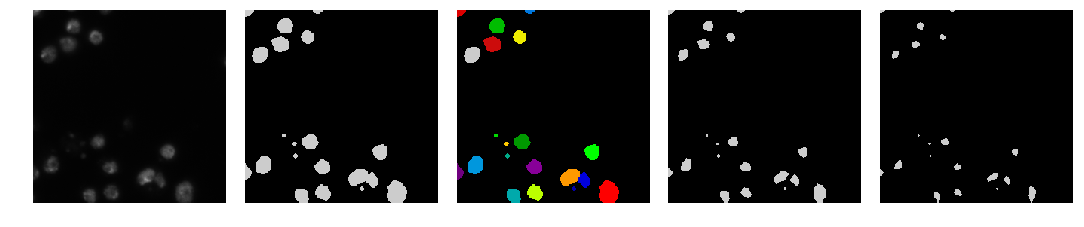

In [26]:
print('Границы значений: images [{}, {}], masks [{}, {}], labels [{}, {}]'.format(
    images[1].min(),
    images[1].max(),
    masks[1].min(),
    masks[1].max(),
    labels[1].min(),
    labels[1].max()
))


draw.plots([
    images[0], masks[0], labels[0], centers[0], centers_1[0]
], col_number=5, scale=3)

In [27]:
!rm -rf ../../data
!rm -rf ../../data/images 
!rm -rf ../../data/masks 
!rm -rf ../../data/centers 
!rm -rf ../../data/distances 
!rm -rf ../../data/test

In [28]:
!mkdir ../../data
!mkdir ../../data/images 
!mkdir ../../data/masks
!mkdir ../../data/test

In [29]:
answers = [np.stack([x, y, z], axis=-1) for x, y, z in zip(masks, centers, centers_1)]

In [30]:
for image, mask, _id in tqdm(zip(images, answers, ids), total=len(ids)):
    cv2.imwrite("../../data/images/{}.png".format(_id), image)
    cv2.imwrite("../../data/masks/{}.png".format(_id), mask)

100%|██████████| 664/664 [00:03<00:00, 195.01it/s]


In [31]:
for image, _id in tqdm(zip(test_images, test_ids), total=len(test_ids)):
    cv2.imwrite("../../data/test/{}.png".format(_id), image)

100%|██████████| 65/65 [00:00<00:00, 217.86it/s]
